<a href="https://colab.research.google.com/github/garylau1/Urban-Heat-Island-UHI-prediction-/blob/main/UHI_Experiment_Sample_Benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Urban Heat Island (UHI) Benchmark Notebook

## Project Overview

<p align="justify">In this project, We developed a machine learning regression model to identify and predict Urban Heat Island (UHI) hotspots in New York City. The primary objective was to estimate the intensity of the UHI effect based on geospatial data.

We utilized a dataset of ground-level air temperature readings collected on July 24, 2021, across traverse points in the Bronx and Manhattan. By training the model on these specific coordinates (latitude and longitude), we was able to predict the UHI Index—a metric indicative of the relative temperature elevation at a specific point compared to the city's average. This project demonstrates the application of regression analysis to solve environmental challenges in urban planning.</p>


<b>Our Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a mechine learning model workflow as our project. The model has been constructed to predict the Urban Heat Island (UHI) index using features from the Sentinel-2 satellite dataset as predictor variables. In this demonstration, we utilized three features from the Sentinel-2 dataset: band B01 (Coastal Aerosol), band B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from bands B04 (Red) and B08 (Near Infrared). A random forest regression model was then trained using these features.
    
These features were extracted from a GeoTIFF image created by the Sentinel-2 sample notebook. For the sample model shown in this notebook, data from a single day (24th July 2021) was considered, assuming that the values of bands B01, B04, B06, and B08 for this specific date are representative of the UHI index behavior at any location. Participants should review the details of the Sentinel-2 sample notebook to gain an understanding of the data and options for modifying the output product.
    
</p>

<p align="justify">Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2-Level-2A notebook</a> found in the Planetary Computer portal.</p>

<p align="justify">Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</p>


## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

In [ ]:
# Supress Warnings
!pip install rioxarray
!pip install pystac_client
!pip install planetary_computer
!pip install geopandas
!pip install rasterio
!pip install pyproj
!pip install sklearn
!pip install rasterstats


import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
from rasterio.warp import transform_bounds
from rasterio.windows import from_bounds

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

import os
import rioxarray as rxr
import pandas as pd
from pyproj import Proj, Transformer
from tqdm import tqdm
from shapely.geometry import Point
import rasterio
import numpy as np
from rioxarray.exceptions import NoDataInBounds  # Import NoDataInBounds exception


# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 4.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Response Variable

Before building the model, we need to load in the Urban Heat Island (UHI) index training dataset. We have curated data for the New York region. The dataset consists of geo-locations (Longitude and Latitude), with additional fields including date & time of data collection and the UHI index for each location.


In [ ]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("Training_data_uhi_index.csv")
ground_df.head()


,Longitude,Latitude,datetime,UHI Index
0,-73.919037,40.814292,24-07-2021 15:53,1.034616
1,-73.918978,40.814365,24-07-2021 15:53,1.028125
2,-73.918927,40.814433,24-07-2021 15:53,1.028125
3,-73.918875,40.814500,24-07-2021 15:53,1.025961
4,-73.918827,40.814560,24-07-2021 15:53,1.025961


## Predictor Variables

### Analyze the Sentinel-2 Data

<p align="justify">Now that we have our UHI data, it is time to gather the predictor variables from the Sentinel-2 dataset</a>. </p>

<p align="justify">Sentinel-2 optical data provides high-resolution imagery that is sensitive to land surface characteristics, which are crucial for understanding urban heat dynamics. Band values such as B01 (Coastal aerosol), B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from B04 (Red) and B08 (Near Infrared) help us in estimating the UHI index. Hence, we are choosing B01, B06, and NDVI as predictor variables for this experiment.</p>

<ul>
<li>B01 - Reflectance values from the Coastal aerosol band, which help in assessing aerosol presence and improving atmospheric correction.</li>

<li>B06 - Reflectance values from the Red Edge band, which provide useful information for detecting vegetation, water bodies, and urban surfaces.</li>

<li>NDVI - Derived from B04 (Red) and B08 (Near Infrared), NDVI is an important indicator for vegetation health and land cover.</li>
</ul>





### Extracting Band Values from the GeoTIFF Image


In [ ]:
final_data = pd.read_csv("/content/Sentinel-2 Data.csv")   #This GeoTIFF dataset is collected from other notebook

In [ ]:
final_data  #We have the wavelengths with different brands which helps us to predict the UHI index

,B01,B03,B04,B06,B08,B11
0,1587.163763,1831.794425,1962.930314,2196.965157,2256.285714,2590.693380
1,1591.017921,1804.526882,1931.365591,2177.827957,2231.935484,2557.949821
2,1592.584775,1800.567474,1928.681661,2175.685121,2241.685121,2545.989619
3,1595.097561,1785.428571,1916.829268,2175.679443,2240.881533,2530.933798
4,1596.933333,1813.778947,1944.122807,2198.887719,2273.498246,2539.175439
...,...,...,...,...,...,...
11264,405.048951,663.381119,456.465035,2830.241259,3668.118881,2105.552448
11265,405.806338,665.035211,458.545775,2828.457746,3666.669014,2103.542254
11266,410.362069,668.162069,463.448276,2826.355172,3656.544828,2101.237931
11267,411.328671,668.328671,463.632867,2825.272727,3651.097902,2097.629371


### Analyze the Landsat Land Surface Data
Now that we have established our search parameters, it is time to gather the temperature data from the Landsat Collection-2 Level-2 dataset.

Landsat-8 provides high-quality thermal data that is essential for generating the Land Surface Temperature (LST) product. To ensure accuracy, we utilize a median mosaic approach over a time series of "low cloud" scenes (less than 20% cloud cover), which statistically removes cloud artifacts from the final image. We have explicitly limited our dataset to Landsat-8 to avoid the data gaps caused by the Scan Line Corrector failure in Landsat-7. Hence, we are choosing the Surface Temperature band, along with the standard spectral bands (Red, Green, Blue, NIR), for this analysis.



In [ ]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data_2(tiff_path, csv_path):

    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)

    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    B01_values = []


# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
        point = Point(lon, lat)
        buffer = point.buffer(0.0006)
        try:
          masked_data = data.rio.clip([buffer], crs=tiff_crs, all_touched=True)
          avg_B01 = masked_data.sel(band=1).mean().item()
          B01_values.append(avg_B01)
        except NoDataInBounds:

          B01_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
          B01_values.append(B01_value)

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['tem'] = B01_values


    return df




In [ ]:
final_data_2 = map_satellite_data_2('Landsat_LST.tiff20%', 'Training_data_uhi_index.csv')

final_data_2.to_csv('final_data_2_smoothing.csv', index=False)

Mapping values: 100%|██████████| 11269/11269 [05:04<00:00, 37.00it/s]


In [ ]:
final_data_2   # we display the temperature data

,tem
0,43.380405
1,43.297660
2,43.299939
3,43.196870
4,43.246162
...,...
11264,34.820767
11265,34.811856
11266,34.808316
11267,34.798594


The <b>Normalized Difference Vegetation Index (NDVI)</b> is used to measure the "greenness" of vegetation and has a range of 0.0 to 1.0. Low values (0.0 to 0.25) reflect a lack of vegetation (bare soil, urban, water), middle values (0.25 to 0.6) reflect grasslands or croplands in their growing state, and high values (0.6 to 1.0) reflect dense vegetation such as trees or croplands at their peak vegetation state. Such information can be relevant to modeling urban heating as the proximity to vegetation or "green space" can mitigate urban heating. The equation uses two spectral bands where: <b>NDVI = (NIR-Red) / (NIR+Red).

In [ ]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.

final_data['NDVI'] = (final_data['B08'] - final_data['B04']) / (final_data['B08'] + final_data['B04'])
final_data['NDVI'] = final_data['NDVI'].replace([np.inf, -np.inf], np.nan)

The <b>Normalized Difference Buildup Index (NDBI)</b> is a ratio-based index that uses the Near Infra-red (NIR) and shortwave-infrared (SWIR) band (1.6 um, Band-11) to highlight built-up areas or areas of urbanization. Low values (below zero) reflect a lack of urbanization and are typical of water or vegetgation. High values (above zero) reflect urbanization with the highest densities where the colors are dark red. Such information can be relevant to modeling urban heating as urban density and increase urban heating. The equation uses two spectral bands where: <b>NDBI = (SWIR-NIR) / (SWIR+NIR).

In [ ]:
final_data['NDWI'] = (final_data['B03'] - final_data['B08']) / (final_data['B03'] + final_data['B08'])
final_data['NDWI'] = final_data['NDWI'].replace([np.inf, -np.inf], np.nan)




The <b>Normalized Difference Water Index (NDWI)</b> is a ratio-based index that uses the Green and Near Infra-Red (NIR) band to highlight areas with surface water. The scale below is set up to highlight areas of water (above zero) in BLUE and areas of non-water (below zero) in RED. Such information can be relevant to modeling urban heating as the proximity to water can mitigate urban heating. The equation uses two spectral bands where: <b>NDWI = (GREEN-NIR) / (GREEN+NIR).

In [ ]:
final_data['NDBI'] = (final_data['B11'] - final_data['B08']) / (final_data['B11'] + final_data['B08'])
final_data['NDBI'] = final_data['NDBI'].replace([np.inf, -np.inf], np.nan)


After that we add these index into our dataset

In [ ]:
final_data.head()


,B01,B03,B04,B06,B08,B11,NDVI,NDWI,NDBI
0,1587.163763,1831.794425,1962.930314,2196.965157,2256.285714,2590.693380,0.069528,-0.103836,0.068993
1,1591.017921,1804.526882,1931.365591,2177.827957,2231.935484,2557.949821,0.072195,-0.105887,0.068063
2,1592.584775,1800.567474,1928.681661,2175.685121,2241.685121,2545.989619,0.075054,-0.109127,0.063560
3,1595.097561,1785.428571,1916.829268,2175.679443,2240.881533,2530.933798,0.077940,-0.113119,0.060784
4,1596.933333,1813.778947,1944.122807,2198.887719,2273.498246,2539.175439,0.078095,-0.112476,0.055204


The value is a scaled reflectance value that represents how much light at a specific wavelength (coastal aerosol band in this case) is reflected from the Earth's surface. To understand this better, let’s break it down:

Simple Analogy:
Think of it like standing outside on a sunny day. You look at the ground and notice that the reflective surface (like snow or a wet road) reflects much more sunlight than the grass does.

If the grass reflects 50% of the sunlight, we might say its reflectance is 0.5 (or 500 when scaled).
If the snow reflects 156% of the sunlight, its reflectance would be 1.56 (or 1561.0 when scaled).



## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_three_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

In [ ]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_three_datasets(dataset1,dataset2,dataset3):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined
    dataset2 - Dataset 2 to be combined
    '''

    data = pd.concat([dataset1,dataset2,dataset3], axis=1)
    return data

Correlation Matrix:
                B01       B04       B06       B08       B03       B11  \
B01        1.000000  0.978829  0.177840 -0.175022  0.974749  0.790144   
B04        0.978829  1.000000  0.201736 -0.153848  0.993247  0.806331   
B06        0.177840  0.201736  1.000000  0.932606  0.295974  0.648421   
B08       -0.175022 -0.153848  0.932606  1.000000 -0.056690  0.361973   
B03        0.974749  0.993247  0.295974 -0.056690  1.000000  0.850376   
B11        0.790144  0.806331  0.648421  0.361973  0.850376  1.000000   
NDVI      -0.825328 -0.830495  0.366853  0.667465 -0.771010 -0.400790   
tem        0.595805  0.592318 -0.161246 -0.375692  0.557487  0.366831   
NDWI       0.835132  0.837325 -0.352989 -0.655957  0.782230  0.413069   
NDBI       0.784572  0.779245 -0.379765 -0.665574  0.720387  0.445356   
UHI Index  0.376878  0.360210  0.105032 -0.028601  0.363742  0.295262   

               NDVI       tem      NDWI      NDBI  UHI Index  
B01       -0.825328  0.595805  0.835132 

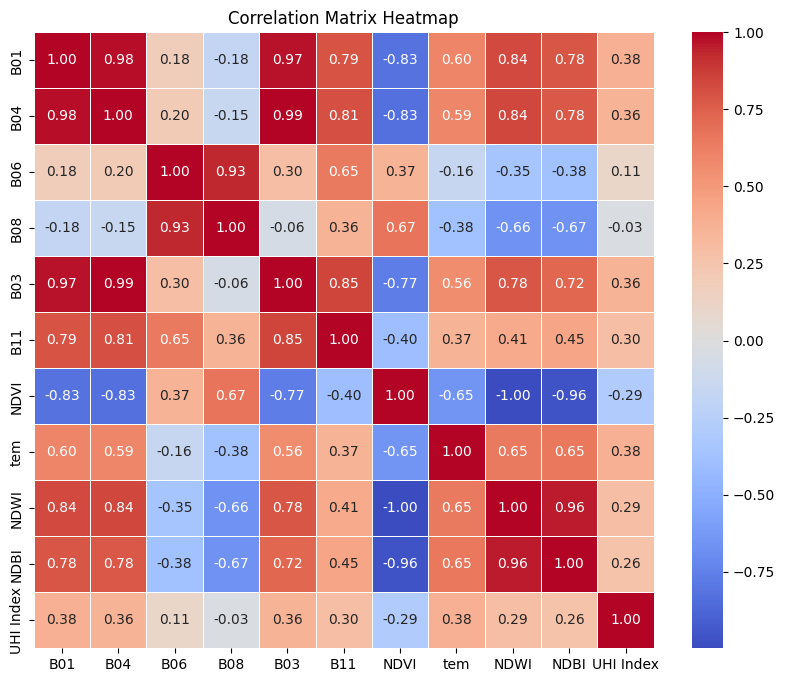

In [ ]:
# Combining ground data and final data into a single dataset.
uhi_data = combine_three_datasets(ground_df,final_data,final_data_2)
#uhi_data.head()
uhi_data = uhi_data[['B01','B04','B06','B08',"B03","B11",'NDVI',"tem","NDWI","NDBI","UHI Index"]]
# Compute the correlation matrix
correlation_matrix = uhi_data.corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [ ]:
uhi_data = combine_two_datasets(ground_df,final_data,final_data_2)
uhi_data.head(4)

,Longitude,Latitude,datetime,UHI Index,B01,B03,B04,B06,B08,B11,NDVI,NDWI,NDBI,tem
0,-73.919037,40.814292,24-07-2021 15:53,1.034616,1587.163763,1831.794425,1962.930314,2196.965157,2256.285714,2590.693380,0.069528,-0.103836,0.068993,43.380405
1,-73.918978,40.814365,24-07-2021 15:53,1.028125,1591.017921,1804.526882,1931.365591,2177.827957,2231.935484,2557.949821,0.072195,-0.105887,0.068063,43.297660
2,-73.918927,40.814433,24-07-2021 15:53,1.028125,1592.584775,1800.567474,1928.681661,2175.685121,2241.685121,2545.989619,0.075054,-0.109127,0.063560,43.299939
3,-73.918875,40.814500,24-07-2021 15:53,1.025961,1595.097561,1785.428571,1916.829268,2175.679443,2240.881533,2530.933798,0.077940,-0.113119,0.060784,43.196870


### Combining meteorological data from New York Mesonet stations

Next we combine the dataset with the weather data from two station ( Bronx and Manhattan)
Our dataset integrates Urban Heat Island (UHI) observations with meteorological data from New York Mesonet stations in the Bronx and Manhattan. By spatially mapping each UHI data point to the nearest station and temporally aligning it with the closest weather timestamp, we have enriched the target UHI indices with real-time atmospheric predictors. This merged dataset, combining geolocation, surface temperatures, and dynamic weather variables, serves as the foundation for training our predictive models to estimate urban heat intensity.



In [ ]:
import pandas as pd
import math

# --- 1. Load Weather Data ---
weather_Bronx = pd.read_excel("NY_Mesonet_Weather.xlsx", sheet_name="Bronx")
weather_Manhattan = pd.read_excel("NY_Mesonet_Weather.xlsx", sheet_name="Manhattan")

# Convert datetime columns
weather_Bronx['Date / Time'] = pd.to_datetime(weather_Bronx['Date / Time'])
weather_Manhattan['Date / Time'] = pd.to_datetime(weather_Manhattan['Date / Time'])

# --- 2. Assign Fixed Coordinates and Station Labels ---
# Bronx station fixed values
weather_Bronx['Longitude'] = -73.89352
weather_Bronx['Latitude'] = 40.87248
weather_Bronx['Altitude'] = 57.5
weather_Bronx['station'] = 'Bronx'

# Manhattan station fixed values
weather_Manhattan['Longitude'] = -73.96449
weather_Manhattan['Latitude'] = 40.76754
weather_Manhattan['Altitude'] = 94.8
weather_Manhattan['station'] = 'Manhattan'

# --- 3. Load UHI Data ---
# Assume Uhi_data is already loaded (or load it similarly, e.g., via read_excel or read_csv)
# For example:
# Uhi_data = pd.read_csv("UHI_data.csv")
#
# Convert the UHI datetime (format "24-07-2021 15:53") to a datetime object.

Uhi_data=combine_two_datasets(ground_df,final_data,final_data_2)
Uhi_data['datetime'] = pd.to_datetime(Uhi_data['datetime'], format='%d-%m-%Y %H:%M')

# --- 4. Assign the Nearest Station to Each UHI Data Row ---
# Define a haversine function to compute distance (in kilometers) between two lat/lon pairs.
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371  # Radius of earth in kilometers.
    return c * r

# Function to assign station based on closest fixed station
def assign_station(row):
    # Calculate distance from the UHI point to each station.
    d_bronx = haversine(row['Longitude'], row['Latitude'], -73.89352, 40.87248)
    d_manhattan = haversine(row['Longitude'], row['Latitude'], -73.96449, 40.76754)
    return 'Bronx' if d_bronx < d_manhattan else 'Manhattan'

# Apply the function to the UHI data.
Uhi_data['station'] = Uhi_data.apply(assign_station, axis=1)

# --- 5. Merge Weather Data with UHI Data Based on Nearest Time ---
# We will perform a merge for each station separately using pd.merge_asof.

# For Bronx:
uhi_bronx = Uhi_data[Uhi_data['station'] == 'Bronx'].copy()
weather_bronx_sorted = weather_Bronx.sort_values('Date / Time')
uhi_bronx_sorted = uhi_bronx.sort_values('datetime')

merged_bronx = pd.merge_asof(
    uhi_bronx_sorted,
    weather_bronx_sorted,
    left_on='datetime',
    right_on='Date / Time',
    direction='nearest',
    suffixes=('', '_weather')
)

# For Manhattan:
uhi_manhattan = Uhi_data[Uhi_data['station'] == 'Manhattan'].copy()
weather_manhattan_sorted = weather_Manhattan.sort_values('Date / Time')
uhi_manhattan_sorted = uhi_manhattan.sort_values('datetime')

merged_manhattan = pd.merge_asof(
    uhi_manhattan_sorted,
    weather_manhattan_sorted,
    left_on='datetime',
    right_on='Date / Time',
    direction='nearest',
    suffixes=('', '_weather')
)

# --- 6. Combine the Merged Data ---
merged_all = pd.concat([merged_bronx, merged_manhattan], ignore_index=True)

# Now 'merged_all' contains your UHI data with corresponding weather measurements,
# which you can use as features to predict the UHI Index.
print(merged_all.head())

   Longitude   Latitude            datetime  UHI Index          B01  \
0 -73.927922  40.824592 2021-07-24 15:01:00   0.997953   966.332168   
1 -73.928163  40.824272 2021-07-24 15:01:00   0.993506  1115.878049   
2 -73.928102  40.824362 2021-07-24 15:01:00   0.993506  1047.874564   
3 -73.927973  40.824518 2021-07-24 15:01:00   1.000117   981.440141   
4 -73.927865  40.824662 2021-07-24 15:01:00   0.997953   951.661972   

           B03          B04          B06          B08          B11  ...  \
0  1162.657343  1240.031469  1523.444056  1567.325175  1624.776224  ...   
1  1156.390244  1212.599303  1641.662021  1742.655052  1726.097561  ...   
2  1156.191638  1215.128920  1606.317073  1705.494774  1693.397213  ...   
3  1165.647887  1237.204225  1553.672535  1601.221831  1649.401408  ...   
4  1148.700704  1227.823944  1498.066901  1551.052817  1598.904930  ...   

          Date / Time  Air Temp at Surface [degC]  \
0 2021-07-24 15:00:00                        28.0   
1 2021-07-24 15:

In [ ]:
list(merged_all.columns)

merged_all['Air Temp at Surface [degC]']

,Air Temp at Surface [degC]
0,28.0
1,28.0
2,28.0
3,28.0
4,28.0
...,...
11264,27.0
11265,27.0
11266,27.0
11267,27.0


## Removing duplicates
Identical or duplicate entries are removed. This ensures that the dataset is not biased or skewed by repetitive data, allowing the model to train on unique, relevant observations.

In [ ]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
uhi_data = merged_all
columns_to_check = ['B01','B04','B06','B08',"B03","B11",'NDVI',"tem","NDWI","NDBI","UHI Index",'Air Temp at Surface [degC]',
 'Relative Humidity [percent]',
 'Avg Wind Speed [m/s]',
 'Wind Direction [degrees]',
 'Solar Flux [W/m^2]',
 'Longitude_weather',
 'Latitude_weather',
 'Altitude']
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')
uhi_data.head()# Resetting the index of the dataset
uhi_data=uhi_data.reset_index(drop=True)
print (len(uhi_data))


11243


## Analyze the Building Footprint Data
We incorporates our final dataset ("Building_Footprint.kml") building footprint geometry to quantify the impact of urban density on heat retention.Instead of a single point data extraction,we also explore the approach of creating a focal buffer around the locations (150 m). For example, if the specified distance was 150 m and the specified band was “Band 2”, then the value of the output pixels from this analysis would reflect the average values in band 2 within 50 meters of the specific location. This approach might help reduction in error associated with spatial autocorrelation.


This generates a "building count" feature, providing crucial context on how the physical built environment contributes to local temperature variations and the overall Urban Heat Island effect.



<h4 style="color:rgb(255, 255, 0)"><strong>Focal buffer around the locations</strong></h4>

In [ ]:
# Install geopandas
!pip install geopandas
!pip install geopandas fiona shapely pyproj
!pip install fastkml
import geopandas as gpd
import pandas as pd
import numpy as np
import geopandas as gpd
from fastkml import kml
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Read the KML file using geopandas.
# Note: The driver='KML' parameter tells geopandas to use the correct driver for KML files.
gdf = gpd.read_file("Building_Footprint.kml", driver="KML")


import pandas as pd
import xml.etree.ElementTree as ET

# Define the KML namespace
ns = {"kml": "http://www.opengis.net/kml/2.2"}

# Parse the KML file (make sure "Building_Footprint.kml" is in your Colab working directory)
tree = ET.parse("Building_Footprint.kml")
root = tree.getroot()

# List to hold data from each Placemark
data = []

# Loop through each Placemark element in the KML file
for placemark in root.findall(".//kml:Placemark", ns):
    placemark_data = {}

    # Extract ExtendedData from SchemaData
    ext_data = placemark.find("kml:ExtendedData", ns)
    if ext_data is not None:
        schema_data = ext_data.find("kml:SchemaData", ns)
        if schema_data is not None:
            for simple_data in schema_data.findall("kml:SimpleData", ns):
                key = simple_data.attrib.get("name")
                placemark_data[key] = simple_data.text.strip() if simple_data.text else None

    # Extract coordinates from the geometry (assuming one polygon per Placemark)
    coord_elem = placemark.find(".//kml:coordinates", ns)
    if coord_elem is not None:
        coords_text = coord_elem.text.strip()
        coords_list = []
        # Split the text into individual coordinate strings
        for coord in coords_text.split():
            parts = coord.split(',')
            lon = float(parts[0])
            lat = float(parts[1])
            # Check if altitude is provided
            if len(parts) > 2:
                alt = float(parts[2])
                coords_list.append((lon, lat, alt))
            else:
                coords_list.append((lon, lat))
        placemark_data["coordinates"] = coords_list

    data.append(placemark_data)

# Create a pandas DataFrame from the collected data
building = pd.DataFrame(data)





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon

# --- Step 1: Convert Building Footprints DataFrame to a GeoDataFrame ---
def create_polygon(coordinate_list):
    # Assumes 'coordinate_list' is a list of (longitude, latitude) tuples.
    return Polygon(coordinate_list)
buildings_df = building
df=uhi_data
# Assuming your building footprints DataFrame is named `buildings_df`
buildings_df['geometry'] = buildings_df['coordinates'].apply(create_polygon)
buildings_gdf = gpd.GeoDataFrame(buildings_df, geometry='geometry', crs='EPSG:4326')

# --- Step 2: Convert UHI DataFrame (df) to a GeoDataFrame ---
df['geometry'] = df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
uhi_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

# --- Step 3: Reproject Both GeoDataFrames to a Projected CRS (e.g., UTM Zone 18N) ---
target_crs = 'EPSG:32618'  # UTM zone for NYC
uhi_gdf = uhi_gdf.to_crs(target_crs)
buildings_gdf = buildings_gdf.to_crs(target_crs)

# --- Step 4: Create Buffers Around Each UHI Point (e.g., 100-meter radius) ---
uhi_gdf['buffer'] = uhi_gdf.geometry.buffer(150)

# For the spatial join, use the buffer as the geometry
buffer_gdf = uhi_gdf.set_geometry('buffer')

# --- Step 5: Spatial Join and Aggregation ---
# Perform the spatial join to find all building footprints that intersect each buffer.
joined = gpd.sjoin(buffer_gdf, buildings_gdf, how='left', predicate='intersects')

# Aggregate building metrics for each UHI point (e.g., count of buildings)
building_metrics = joined.groupby(joined.index).agg({
    'id': 'count'  # Using 'id' as a unique identifier for buildings
})
building_metrics.rename(columns={'id': 'building_count'}, inplace=True)

# Merge the new feature back into your UHI GeoDataFrame
uhi_gdf = uhi_gdf.join(building_metrics)

# If you wish to convert back to a pandas DataFrame without geometry:
final_df = pd.DataFrame(uhi_gdf.drop(columns=['geometry', 'buffer']))

# Now, final_df contains a new column "building_count" that you can use as a feature for your model.



## We plot some bluffers

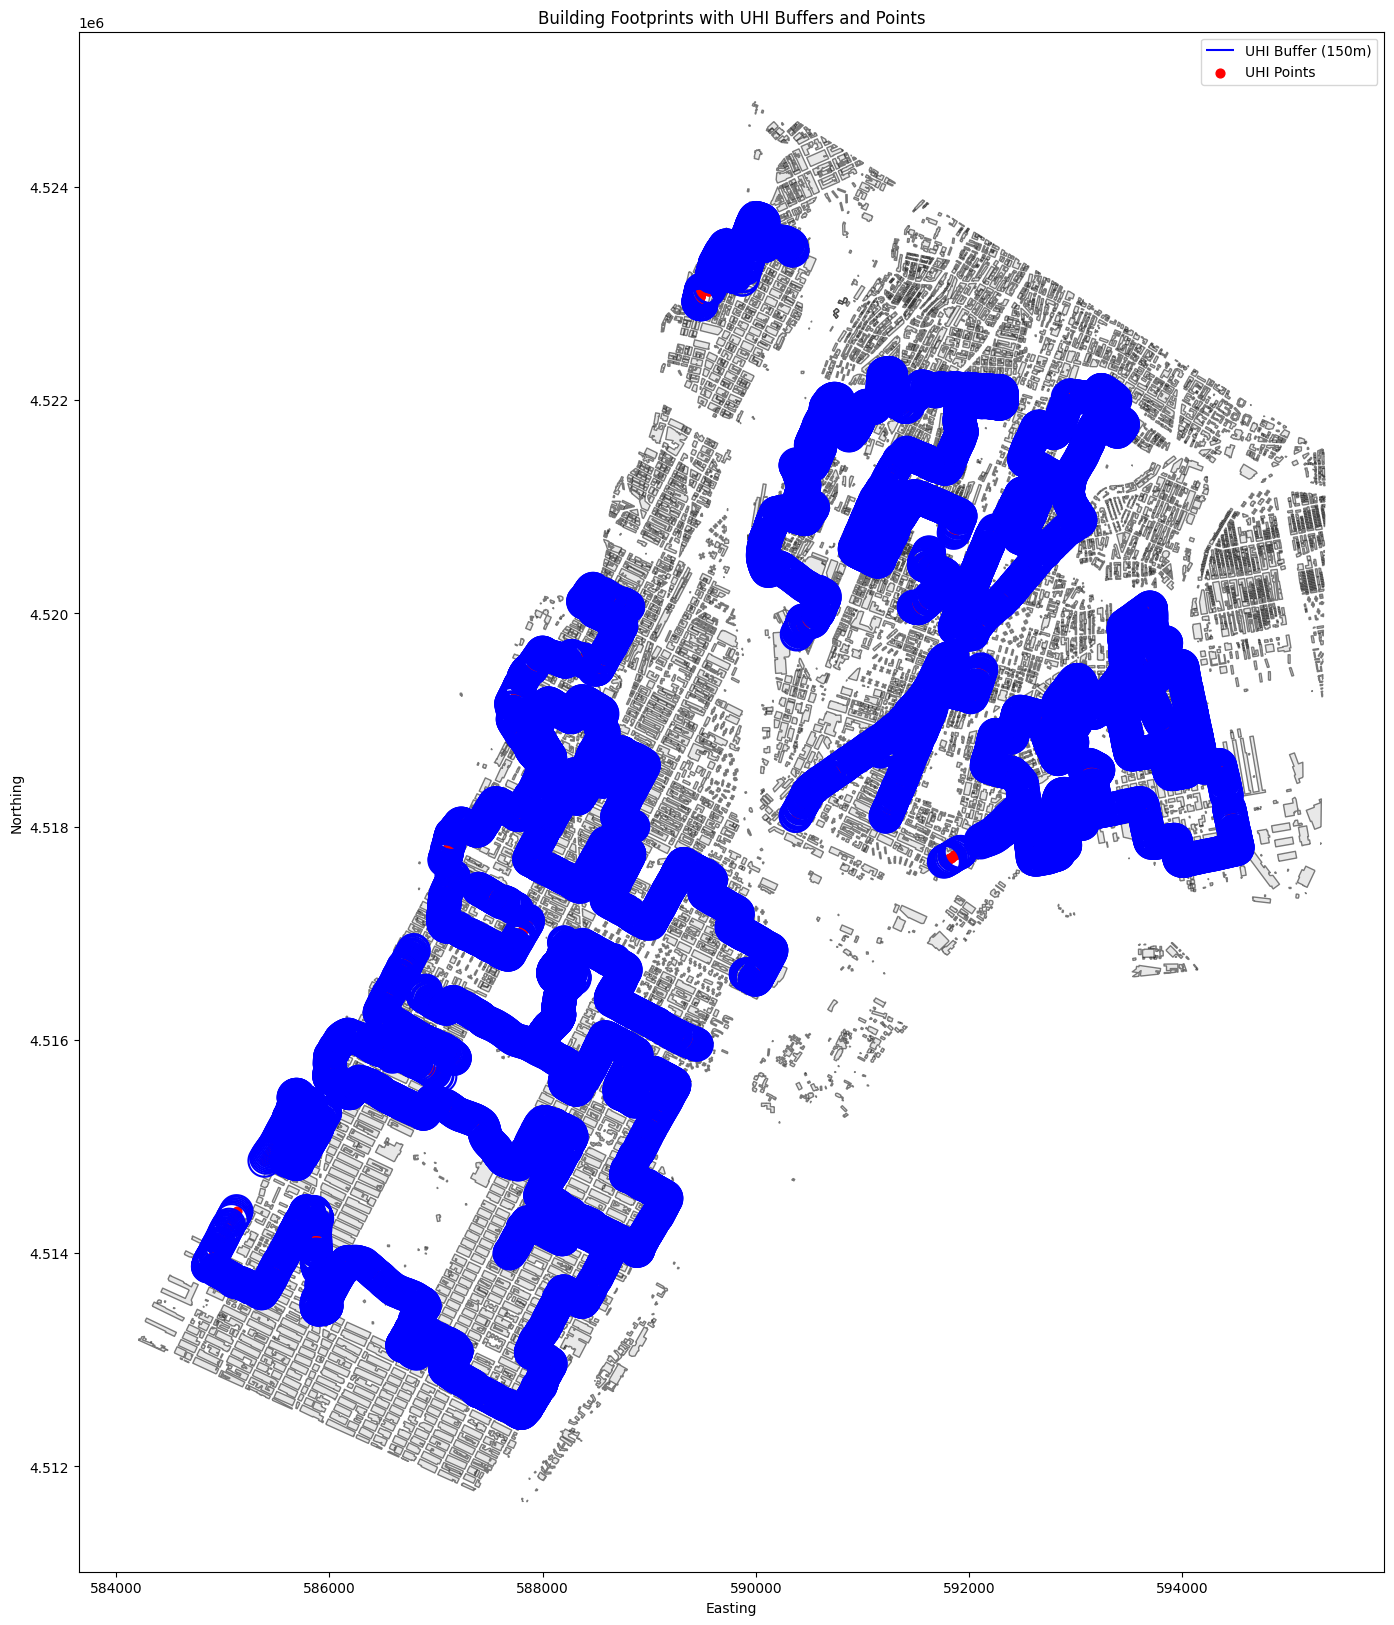

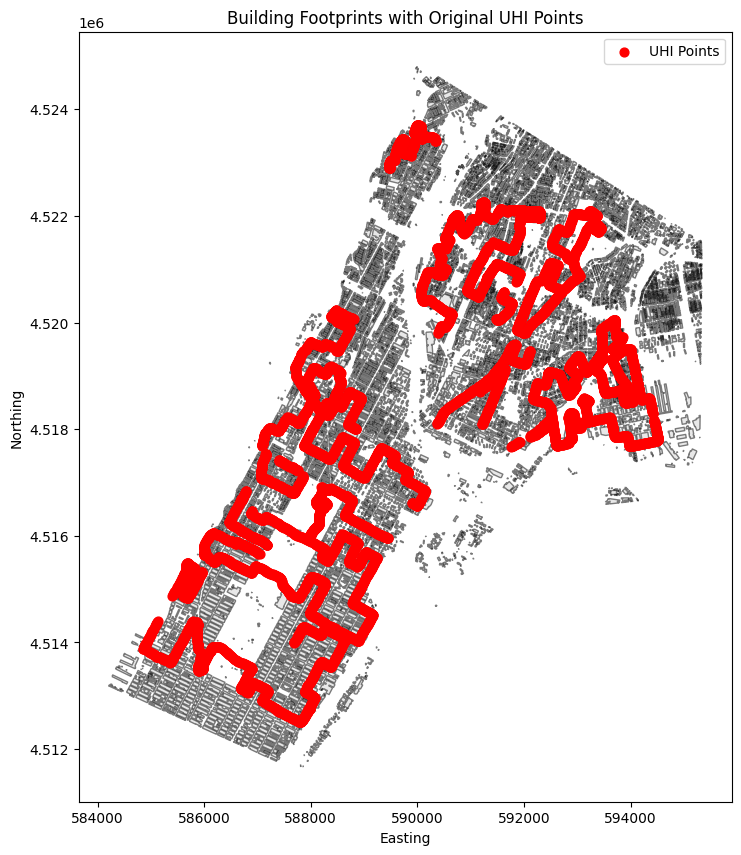

In [ ]:
import matplotlib.pyplot as plt

# ---- Plot 1: Building Footprints with UHI Buffers and UHI Points ----

# Create a figure and axis.
fig, ax = plt.subplots(figsize=(20, 20))

# Plot building footprints.
buildings_gdf.plot(ax=ax, facecolor='lightgray', edgecolor='black', alpha=0.5, label='Buildings')

# Plot UHI buffers (note: these are polygon geometries).
buffer_gdf.boundary.plot(ax=ax, color='blue', linewidth=1.5, label='UHI Buffer (150m)')

# Plot UHI points (using the original point locations, here we'll extract them from the original df)
uhi_points_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']),
    crs='EPSG:4326'
)
uhi_points_gdf = uhi_points_gdf.to_crs(target_crs)
uhi_points_gdf.plot(ax=ax, color='red', markersize=40, label='UHI Points')

# Add title and legend.
plt.title("Building Footprints with UHI Buffers and Points")
plt.legend()
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.show()


# ---- Plot 2: Building Footprints with Original UHI Points (No Buffers) ----

fig, ax = plt.subplots(figsize=(10, 10))

# Plot building footprints.
buildings_gdf.plot(ax=ax, facecolor='lightgray', edgecolor='black', alpha=0.5, label='Buildings')

# Plot only the original UHI points.
uhi_points_gdf.plot(ax=ax, color='red', markersize=40, label='UHI Points')

# Add title and legend.
plt.title("Building Footprints with Original UHI Points")
plt.legend()
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.show()

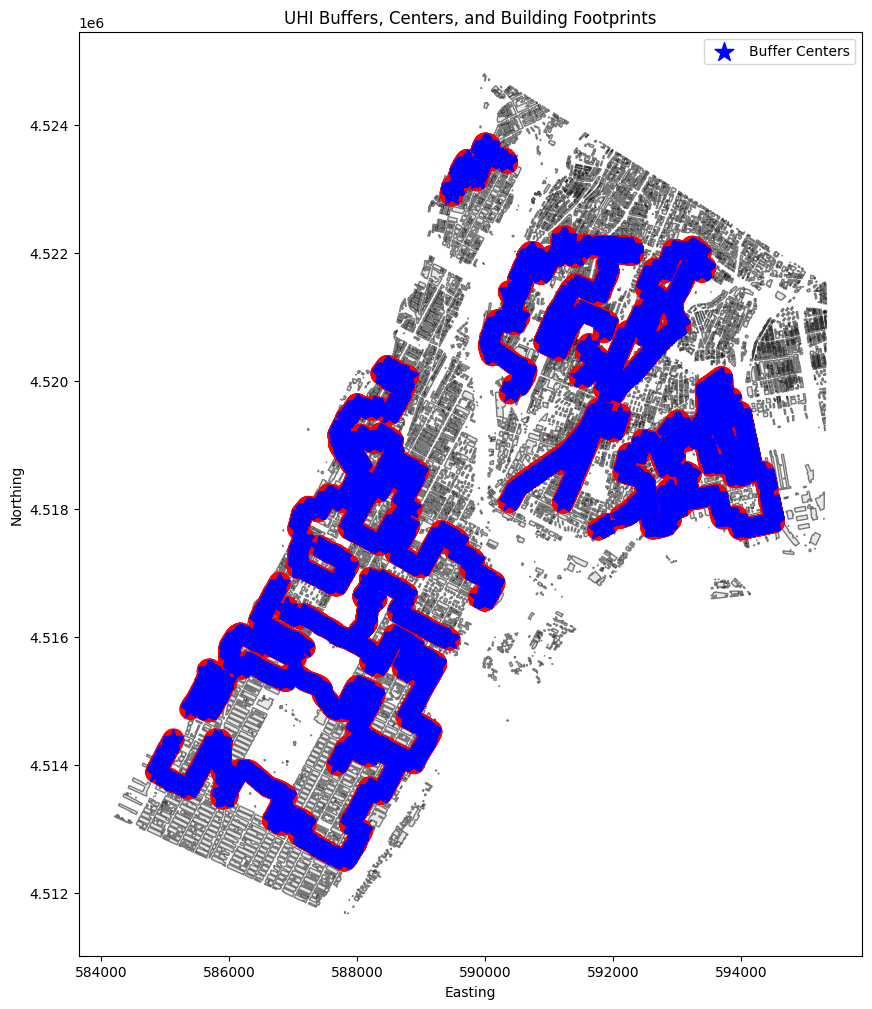

In [ ]:
import matplotlib.pyplot as plt

# Create a plot with a defined figure size
fig, ax = plt.subplots(figsize=(12, 12))

# Plot building footprints in a light gray color with black edges
buildings_gdf.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)

# Plot UHI buffers with a red outline and no fill to highlight intersections
buffer_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Plot the center of each UHI buffer (original UHI points) as star markers
# Using scatter from matplotlib to plot star markers
centers = uhi_gdf.geometry
ax.scatter(centers.x, centers.y, marker='*', color='blue', s=200, label='Buffer Centers')

# Optionally, add title, labels, and legend
plt.title("UHI Buffers, Centers, and Building Footprints")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.legend()

# Display the plot
plt.show()

## This is out final dataset before training a model

Correlation Matrix:
                                  B01       B04       B06       B08       B03  \
B01                          1.000000  0.978821  0.177645 -0.175268  0.974761   
B04                          0.978821  1.000000  0.201412 -0.154231  0.993248   
B06                          0.177645  0.201412  1.000000  0.932585  0.295633   
B08                         -0.175268 -0.154231  0.932585  1.000000 -0.057103   
B03                          0.974761  0.993248  0.295633 -0.057103  1.000000   
B11                          0.790098  0.806197  0.648289  0.361777  0.850252   
NDVI                        -0.825301 -0.830561  0.367033  0.667650 -0.771101   
tem                          0.595894  0.592345 -0.161586 -0.376067  0.557496   
NDWI                         0.835089  0.837369 -0.353205 -0.656173  0.782298   
NDBI                         0.784551  0.779301 -0.379933 -0.665739  0.720474   
UHI Index                    0.377423  0.360626  0.105090 -0.028785  0.364152   
building

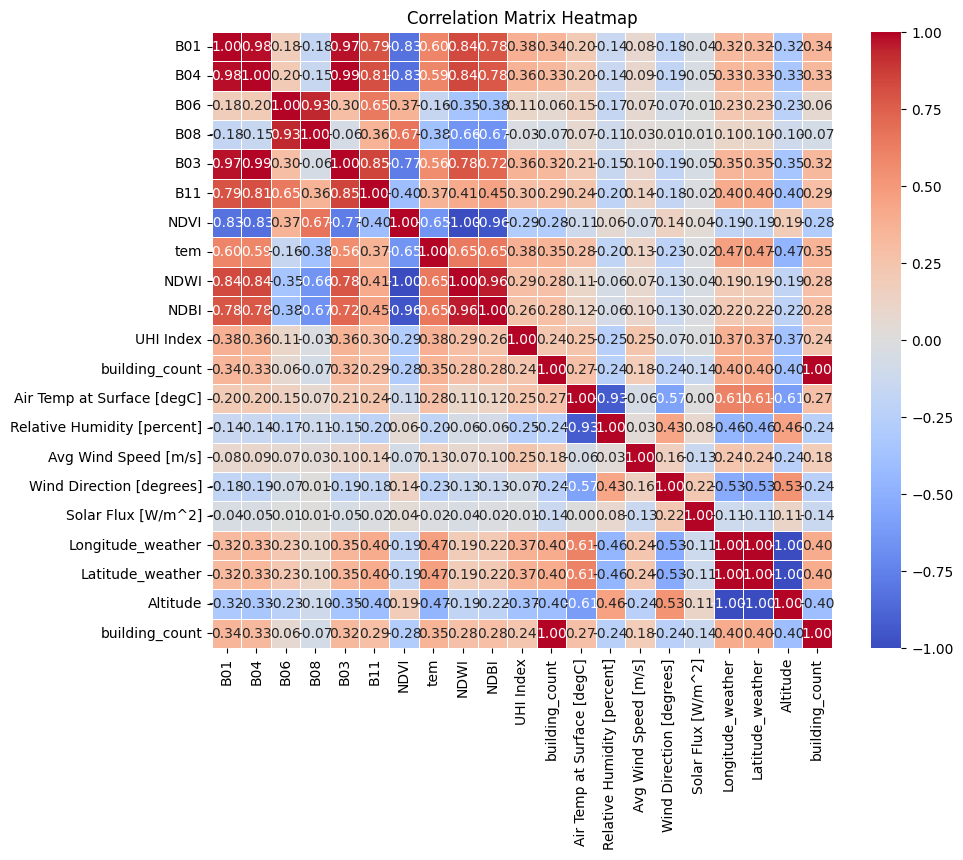

In [ ]:
# Compute the correlation matrix
uhi_data=final_df[['B01','B04','B06','B08',"B03","B11",'NDVI',"tem","NDWI","NDBI","UHI Index","building_count",'Air Temp at Surface [degC]',
       'Relative Humidity [percent]', 'Avg Wind Speed [m/s]',
       'Wind Direction [degrees]', 'Solar Flux [W/m^2]', 'Longitude_weather',
       'Latitude_weather', 'Altitude', 'building_count']]
correlation_matrix = uhi_data.corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [ ]:
final_df.columns

Index(['Longitude', 'Latitude', 'datetime', 'UHI Index', 'B01', 'B03', 'B04',
       'B06', 'B08', 'B11', 'NDVI', 'NDWI', 'NDBI', 'tem', 'station',
       'Date / Time', 'Air Temp at Surface [degC]',
       'Relative Humidity [percent]', 'Avg Wind Speed [m/s]',
       'Wind Direction [degrees]', 'Solar Flux [W/m^2]', 'Longitude_weather',
       'Latitude_weather', 'Altitude', 'station_weather', 'building_count'],
      dtype='object')

In [ ]:
list1=['B01','B04','B06','B08',"B03","B11",'NDVI',"tem","NDWI","NDBI","UHI Index","building_count",'Air Temp at Surface [degC]',
       'Relative Humidity [percent]', 'Avg Wind Speed [m/s]',
       'Wind Direction [degrees]', 'Solar Flux [W/m^2]', 'Longitude_weather',
       'Latitude_weather', 'Altitude']


uhi_data=final_df[list1]

columns_to_check=list1

for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')

# Resetting the index of the dataset
uhi_data=uhi_data.reset_index(drop=True)

uhi_data.head()

,B01,B04,B06,B08,B03,B11,NDVI,tem,NDWI,NDBI,UHI Index,building_count,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2],Longitude_weather,Latitude_weather,Altitude
0,966.332168,1240.031469,1523.444056,1567.325175,1162.657343,1624.776224,0.116584,42.748214,-0.148231,0.017998,0.997953,14,28.0,40.3,3.0,75,725,-73.89352,40.87248,57.5
1,1115.878049,1212.599303,1641.662021,1742.655052,1156.390244,1726.097561,0.179360,42.581699,-0.202227,-0.004773,0.993506,13,28.0,40.3,3.0,75,725,-73.89352,40.87248,57.5
2,1047.874564,1215.128920,1606.317073,1705.494774,1156.191638,1693.397213,0.167898,42.922271,-0.191951,-0.003559,0.993506,13,28.0,40.3,3.0,75,725,-73.89352,40.87248,57.5
3,981.440141,1237.204225,1553.672535,1601.221831,1165.647887,1649.401408,0.128246,43.054411,-0.157425,0.014822,1.000117,14,28.0,40.3,3.0,75,725,-73.89352,40.87248,57.5
4,951.661972,1227.823944,1498.066901,1551.052817,1148.700704,1598.904930,0.116316,43.079389,-0.149033,0.015191,0.997953,15,28.0,40.3,3.0,75,725,-73.89352,40.87248,57.5


###Predictive Modeling and Evaluation


In this final phase, we leverage our integrated dataset—combining spectral imagery, meteorological records, and building metrics—to predict the UHI Index. We utilize a Random Forest Regressor, a robust ensemble learning method well-suited for capturing complex, non-linear interactions between variables like surface temperature, wind speed, and urban density. Our rigorous modeling pipeline involves feature scaling, automated feature selection to isolate the most impactful predictors (such as tem and building_count), and hyperparameter tuning via RandomizedSearchCV. Finally, we assess the model’s generalization capability by evaluating the $R^2$ score on an independent test set.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score

X = uhi_data.drop(columns=['UHI Index']).values
y = uhi_data['UHI Index'].values

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build a pipeline that includes scaling, feature selection, and the RandomForestRegressor.
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(RandomForestRegressor(random_state=42))),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define the hyperparameter distributions for the RandomForestRegressor step.
# Note: The parameters are prefixed with "regressor__" to indicate they belong to the regressor within the pipeline.
param_dist = {
    'regressor__n_estimators': [250,280, 300,320,340,360,400,450,500],
    'regressor__max_depth': [None, 20,30,40,50,60,70,80,90],
    'regressor__min_samples_split': [2,3,4,5,6],
    'regressor__min_samples_leaf': [1],
    'regressor__bootstrap': [True]
}

# Set up RandomizedSearchCV to search for the best hyperparameters.
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=10,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

# Fit the randomized search on the training data.
random_search.fit(X_train, y_train)

# Output the best parameters and the best cross-validation R² score.
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation R² Score:", random_search.best_score_)

# Evaluate the tuned model on the test set.
y_pred = random_search.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
print("Test R² Score:", test_r2)

Best Parameters: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 50, 'regressor__bootstrap': True}
Best Cross-Validation R² Score: 0.8749862489881709
Test R² Score: 0.8948156156809209


In [ ]:
# Get the best pipeline from RandomizedSearchCV
best_pipeline = random_search.best_estimator_

# Retrieve the feature selector from the pipeline
selector = best_pipeline.named_steps['feature_selection']

# The selector provides a boolean mask of the selected features.
# This mask corresponds to the columns in the original X (before scaling).
selected_mask = selector.get_support()

# List of feature names used in the model
feature_names = uhi_data.drop(columns=['UHI Index']).columns
selected_features = feature_names[selected_mask]

print("Selected features:", selected_features.tolist())

Selected features: ['B01', 'tem', 'NDWI', 'building_count', 'Avg Wind Speed [m/s]', 'Wind Direction [degrees]']


In [ ]:
final_df[list1].columns

Index(['B01', 'B04', 'B06', 'B08', 'B03', 'B11', 'NDVI', 'tem', 'NDWI', 'NDBI',
       'UHI Index', 'building_count', 'Air Temp at Surface [degC]',
       'Relative Humidity [percent]', 'Avg Wind Speed [m/s]',
       'Wind Direction [degrees]', 'Solar Flux [W/m^2]', 'Longitude_weather',
       'Latitude_weather', 'Altitude'],
      dtype='object')

In [ ]:
uhi_data = final_df[list1]
uhi_data.head()

,B01,B04,B06,B08,B03,B11,NDVI,tem,NDWI,NDBI,UHI Index,building_count,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2],Longitude_weather,Latitude_weather,Altitude
0,966.332168,1240.031469,1523.444056,1567.325175,1162.657343,1624.776224,0.116584,42.748214,-0.148231,0.017998,0.997953,14,28.0,40.3,3.0,75,725,-73.89352,40.87248,57.5
1,1115.878049,1212.599303,1641.662021,1742.655052,1156.390244,1726.097561,0.179360,42.581699,-0.202227,-0.004773,0.993506,13,28.0,40.3,3.0,75,725,-73.89352,40.87248,57.5
2,1047.874564,1215.128920,1606.317073,1705.494774,1156.191638,1693.397213,0.167898,42.922271,-0.191951,-0.003559,0.993506,13,28.0,40.3,3.0,75,725,-73.89352,40.87248,57.5
3,981.440141,1237.204225,1553.672535,1601.221831,1165.647887,1649.401408,0.128246,43.054411,-0.157425,0.014822,1.000117,14,28.0,40.3,3.0,75,725,-73.89352,40.87248,57.5
4,951.661972,1227.823944,1498.066901,1551.052817,1148.700704,1598.904930,0.116316,43.079389,-0.149033,0.015191,0.997953,15,28.0,40.3,3.0,75,725,-73.89352,40.87248,57.5


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# Starting from your provided uhi_data selection:
uhi_data = final_df[list1]
X = uhi_data.drop(columns=['UHI Index'])
y = uhi_data['UHI Index']

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Use only the selected features
#X = uhi_data[selected_features.tolist()].values
X = uhi_data[['B01', 'tem', 'NDWI', 'building_count', 'Avg Wind Speed [m/s]', 'Wind Direction [degrees]']]
y = uhi_data['UHI Index'].values

# Split the data (using a fixed random_state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the RandomForestRegressor using the given hyperparameters
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=50,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,

)


model.fit(X_train_scaled, y_train)

# Predict on training and test sets
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Calculate and print the R² scores
print("Train R² Score:", r2_score(y_train, y_train_pred))
print("Test R² Score:", r2_score(y_test, y_test_pred))

final_df.to_csv("final_dataset.csv", index=False)

Train R² Score: 0.9873066447259714
Test R² Score: 0.9018882972366326


##Results and AnalysisModel Performance


Results and AnalysisModel PerformanceThe Random Forest Regressor demonstrated strong predictive capability, achieving a Train $R^2$ of 0.987 and a Test $R^2$ of 0.902. The high test score indicates that the model generalizes well to unseen data, explaining approximately 90% of the variance in the Urban Heat Island (UHI) index. While the gap between training and testing scores suggests mild overfitting—common in ensemble methods applied to complex spatial data—the overall performance confirms the model's reliability for estimating urban heat intensity.


B01                            0.377423
B04                            0.360626
B06                            0.105090
B08                           -0.028785
B03                            0.364152
B11                            0.295414
NDVI                          -0.288884
tem                            0.376033
NDWI                           0.294491
NDBI                           0.262492
building_count                 0.241706
Air Temp at Surface [degC]     0.254931
Relative Humidity [percent]   -0.252900
Avg Wind Speed [m/s]           0.245068
Wind Direction [degrees]      -0.072215
Solar Flux [W/m^2]            -0.008502
Longitude_weather              0.369934
Latitude_weather               0.369934
Altitude                      -0.369934
Name: UHI Index, dtype: float64


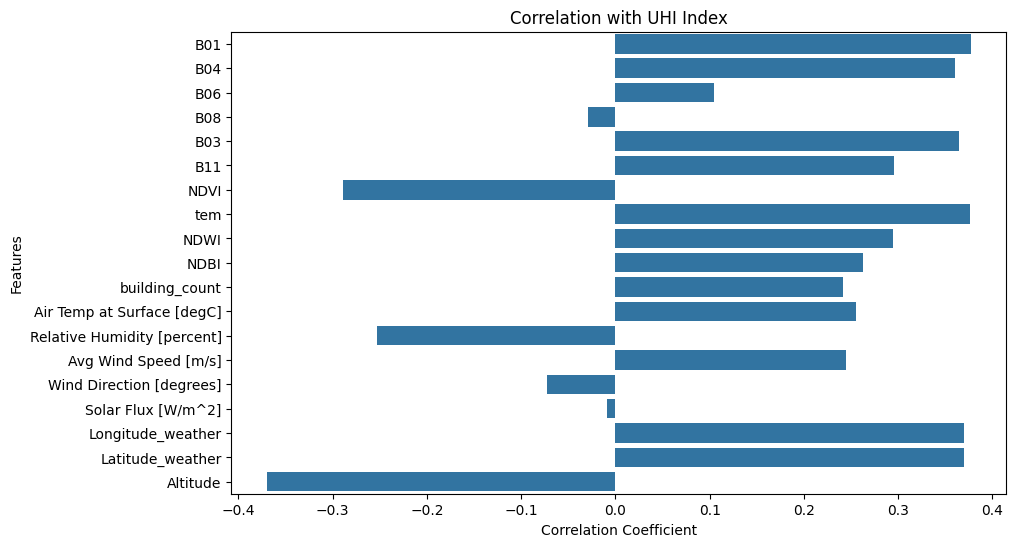

In [ ]:
correlations = uhi_data.corr()['UHI Index'].drop('UHI Index')  # Exclude UHI Index itself

print(correlations)

# Optional: Visualize the correlations
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.barplot(x=correlations.values, y=correlations.index)
plt.title('Correlation with UHI Index')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()




###Correlation Analysis



The analysis reveals distinct physical drivers of urban heat, with spectral data and built environment metrics showing the strongest positive associations. Lower wavelength bands like B01 (Coastal Aerosol, 0.38), B03 (Green, 0.36), and B04 (Red, 0.36) exhibited the highest positive correlations, likely capturing atmospheric scattering and surface reflectance typical of urban structures. This is further supported by the positive relationship with NDBI (0.26) and building_count (0.24), confirming that higher building density and impervious surfaces directly contribute to heat retention. Meteorological factors also play a role, with Air Temperature (0.25) and Avg Wind Speed (0.25) aligning with higher UHI intensity. Conversely, natural features act as significant cooling agents. Altitude (-0.37) and NDVI (-0.29) showed strong negative correlations, demonstrating that higher elevations and increased vegetation effectively mitigate heat through natural cooling and evapotranspiration. Relative Humidity (-0.25) also acts as a moderating factor, where higher atmospheric moisture is associated with reduced thermal intensity. These findings validate that the model successfully captures the physical reality where dense, low-altitude urban areas trap heat while vegetation and topography provide relief.